# Random Forest

### In this NB I shall be following along with  Jeremy H as he goes through the intro to machine learning lessons. We start with the Random Forest algorithm.

The lesson we're following today is from the FastAI ML MOOC which ran in late 2018, it is taught by Jeremy H and Rachel, it is ideal for anyone who wants to break in to Machine learning or someone wanting to learn about ML Algorithms.

Dataset
The Dataset is from Kaggle, it's from an old competition about the Bulldozzers sales. We have four years worth of data and the aim is to predicate the __Sale Price__ for a future time.

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import feather


In [3]:
import seaborn as sns
plt.style.use('fivethirtyeight')

In [4]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

##### Importing the data 

In [5]:
PATH = "excel/Train.csv"

###### A few things to Note:
* FastAi is a library coded by the FastAi team.
* The library is built on top of the famous open source libraries like SK_Learn and Pandas.
* It's advisable to check out the FastAi forum whenever you find yourself stuck.


### About the Algorithm

Random Forest is one of the most important algorithms in data science, it is pretty much the go to technic for the all problems. Understanding this algorithm will put you in a very good position for rest of your time as a data scientist.

Random Forest is based of building a tree from the data, you build this tree using features. we then build a forest of these tree and use the averages to pick out insights. 

In [6]:
%%time
# This code takes a while depending on your 
# We can set it to low memory to alert pandas of the capability of our machine
# We also Pasrse the target feature as dates

raw_data = pd.read_csv("excel/Train.csv", low_memory=False, 
                     parse_dates=["saledate"])

Wall time: 3min 51s


We check out the head of the data to see how it looks like, doing this can be insightful especially at the beginning of the analysis

In [7]:
raw_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What we see from the above table is that we have fifty three features and the data has both numerical and categorical features.
Having a look at the head is a go to method for a quick look but for insight we need to look at our data in various ways before we start playing with it, this helps us rule out what kind of techniques will not work and how to go about playing with our data.

For this we need a function that will us with this task, the **_display-all()_** functions helps us to see the data in different way, we use pandas to do this.

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
raw_data.tail()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401124,6333342,7750,1926965,21435,149,2.0,2005,NaN,NaN,2011-10-25,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [10]:
display_all(raw_data.tail())

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401124,6333342,7750,1926965,21435,149,2.0,2005,NaN,NaN,2011-10-25,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [11]:
display_all(raw_data.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [12]:
display_all(raw_data.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
raw_data.SalePrice = np.log(raw_data.SalePrice)

In [14]:
raw_data.SalePrice

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
5         10.184900
6          9.952278
7         10.203592
8          9.975808
9         11.082143
10        10.085809
11        10.021271
12        10.491274
13        10.325482
14        10.239960
15         9.852194
16         9.510445
17         9.159047
18         9.433484
19         9.350102
20        10.621327
21        10.448715
22        10.165852
23        11.198215
24        10.404263
25         9.433484
26         9.648595
27        10.878047
28        10.736397
29        11.396392
            ...    
401095     9.259131
401096     9.210340
401097     9.047821
401098     9.259131
401099     9.305651
401100     9.259131
401101     9.210340
401102     9.259131
401103     9.433484
401104     9.259131
401105     9.210340
401106     9.259131
401107     9.433484
401108     9.259131
401109     9.259131
401110     9.259131
401111     9.210340
401112     9.259131
401113     9.259131


## Initial Processing 

The data is its current condition we can't really do much with it even for exploratory analysis, we need to process it first before we can do something.

**Note:** If you're not familiar with a function you can just type two question marks and the function to see what the function does, I use it to find out more about a function in the next cell.

The function in question is from FastAi library we use it to add convert a column of df from a datetime64 to many columns containing the information from the date.

In [15]:
??add_datepart

In [16]:
raw_data.saledate.head(3)

0   2006-11-16
1   2004-03-26
2   2004-02-26
Name: saledate, dtype: datetime64[ns]

After applying the function

In [17]:
add_datepart(raw_data,'saledate')
raw_data.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

Splitting the data this way will help us to get a better insight in the __saledates__ feature, if you use the Jupyter magic on the function you would have seen that the function splits the feature helps us to extract a lot more data that we would not have had, had we just use it in its pure form. We also have new columns as a result of calling this functions on the data. 

A quick look at the way our dataset looks after the **add_datepart** functions.
Notice we have added more columns to our table.

In [18]:
raw_data.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600


The next this to deal with the state of our dataset, for example we would like our dataset to have all the features in a numerical form, however we have some columns which are strings, so we need to deal with these columns before we start training. 

We shall use the train cats function also from the FirstAi library what it does, it changes any columns of strings in a panda's dataframe to a column of categorical values. This applies the changes inplace.

In [19]:
train_cats(raw_data)

In [20]:
raw_data.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Lets take another quick look at our dataset to see what we have done so far 

In [21]:
raw_data.head(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


Two things to note here; we still have strings in our dataset despite calling the train function which was supposed to change them into numerical values, we also have boolean values in our dataset, these will be represented as 0 and 1 during the processing even though at the moment Pandas shows it to us as Strings, they are really boolean values ie 0 and 1 version will be used during the processing.

In [22]:
raw_data.UsageBand = raw_data.UsageBand.cat.codes

We are still not quite done, for instance we have lots of missing values, which we can't pass directly to a random forest. There are various ways to deal with null values in a dataset, here we shall employ the fillna values method which fills null values with approximate values, this method can backfire so care must be taken when choosing a method to deal with null values.

In [23]:
display_all(raw_data.isnull().sum().sort_index()/len(raw_data))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

Doing this kind of processing is bit risky on the actual dataset especially when you're working on actuall data, it is recommeded to make a copy of the data and play with this copy so permanet changes wont affect the original data especially during the processing real damage can be done.

In [102]:
#To make a temp 
os.makedirs('tmp',exist_ok=True)
raw_data.to_feather('tmp/bulldozers-raw1')

From now on we shall be using this copy, there are two main advantages to use this copy, its quicker incase our notebook goes down we can just begin were we stop. Its also safer in terms of things going bad.

### Pre-processing

In [103]:
raw_data = feather.read_dataframe('tmp/bulldozers-raw1')

Now we can deal with the other categorical features without worrying that they will disrupt our original dataset, we still havent dealt with the null values in the dataset.
We're going to use the **proc_df()** function again from FastAi to replace the categorical data with numerical values in order to handle missing values, we shall also split the dependant variable into a seperable variable.

In [104]:
df, y, nas = proc_df(raw_data, 'SalePrice')

A quick lookat the state of our columns after calling the proc_df functions 

In [105]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [106]:
# a quick look at the head again
df.tail(4)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
401121,6333337,1830472,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True
401124,6333342,1926965,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


In [107]:
#df.info()

We can confrim that we no longer have null and data of the type String in our dataset.

We now have our d,ata in a form that can be used to pass it in a random forest, we shall be using Sklearn model **RandomForestRegressor**

## Base Model

##### Unrealistic model

In [108]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(df, y)
m.score(df,y)

Wall time: 13.2 s


0.9080088634838953

What have we done here?
* 1. We called our model the default is ten trees in Sklearn
* 2. We fit our model to the data 
* 3. We called th score function to see how we did.

Bear in mind that we havent done any thing other than processing the data, the .98 value above represents the RSquared, this is the same value we use to judge how well the model did.
But this sis not enogh infact this is not how you would do it in a real scenario, because we used all our data dring the fitting process we have no way of knowing how our model will perform on unseen data.

This is where the idea of seperating data comes in, the idea is we seperate data into two sets the training set and the validaton set, we do this because not doing so might risk us to over fit as we did in the earlier model. The only way we can know if we're overfiting or not is to try our model on new data to see if we get the same results as we did before.

**Splitting the data:** 
We're going to define a split function, the function will split our data into two copies, the first copy starts from the beginning to some random _**n**_ and the other copy begins from _**n**_ to the end of dataset.
We set out validation set to be 12000, its 12000 because this is the same value that was set by the organizers of Kaggle competition in the original competition. We also set our training set as the rest of the data after subtracting the validation set.

In [109]:
def split_vals(a,n): 
    
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(raw_data, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

After spliting we can try to build another model but this time we have split the data, we're in a better position to fight against biases and overfiting problems.  

In [110]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [111]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 13.2 s
[0.20938326269148214, 0.2647360722006933, 0.9083739948762837, 0.8748375037476521]


#### Speeding things up

One of the main advertages of working in a jupyter notebook is that it allows us to interact with our code on the go, this is normally easy when were working with a small dataset however it becomes increasly difficult on lager datasets, data sciencetist are therfore always on the look out for how to speed things up.
One of the ways that the have comeup with is selecting a subset of data from the original data and building a model on a subset then try the findings on the whole dataset later. 

In [112]:
df_trn, y_trn, nas = proc_df(raw_data, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [113]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 4.04 s
[0.037899450563463555, 0.36109988128329573, 0.9968870470174965, 0.7671358326881392]


As you can see in the above results, even though we worked on a smaller dataset we still managed to get close to the same result as we did earlier when we still had the whole dataset. The main thing I would like to draw your attention to is how fast it ran compared to the first model.

|DataSet | Model | **Speed(time_secs)**|
|--------|-------|---------------------|
|Whole   |RFR    |40 secs              |
|Subset  | RFR   | 1.4 secs            |

## Single tree

In order to fully understand Random Forest Regression, we have to have an idea of where it gets its name and how it comes about. We start with Forest a word that most of us will be familiar with, the use of this word gives us a sense that the a model has something to do with trees, which it does, the model its self is an extension of another popular model called __Decision Tree__, this model as the name suggest builds a tree using data features selecting the best metric for the feature in each branch until it reaches to the last leaf.

As we mentioned earlier, we use scikit learn library, in scikit learn the trees are referred to as estimators, the depth is how deep do you want the tree to go and the number of jobs is how many times you want the model to run.

In [114]:
m = RandomForestRegressor(n_estimators=1, max_depth=5, bootstrap=False, n_jobs=-1) 
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 329 ms
[0.4355978271558431, 0.46882655054960776, 0.5887762938756879, 0.6074704365793681]


In [115]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.153480596427405e-17, 0.47911061724075704, 1.0, 0.5900606915726602]


### Bagging Method

#### Introduction to Bagging method

__Bagging__(predictive but poorly correlated trees) method also known as is the idea of having multiple trees to get more generalized results. As way of  example we can imagine having a forest in this forest all trees have features that can used to make predictions about the forest, however, these __features errors__ are not correlated, i.e if we calculate the average of theses predictive features we would get zero. This brings us to a more known technique of __Ensembling__;  this technique basically just pick a subset of data randomly from a sample, build a tree using that subset, do that again and again while collecting the data like averages. These subsets will probably be over-fitting but it will only be to their on subset since it was randomly selected we can    calculate the average of the average which is how we get a **Random Forest** 

Basically a __Random Forest__ is a collection of crappy models which are better than nothing, the important thing is the errors in these crappy models must not be correlated with other, then use these crappy models data

one other thing might encounter when dealing with Random forests model is the idea of __BootStrapping__; this can be defined as picking a subset of rows from a sample randomly, but to make sure each pick we have at least one replacement, this allows overlapping of the rows but at the same time with the replacement we get more insight every random pick basically no two random picks will give us the same thing

In [116]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.03721728523213553, 0.3749331746897103, 0.9969981007308458, 0.7489526089814446]


With the help of bagging our model has improved, but again we have to remember that we're just working with ten trees(Estimators) imagine if we were working with more trees, infact we can plot a graph to see how each of our estimators fairs.



In [117]:
preds = np.stack([r.predict(X_valid) for r in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.04782, 9.21034, 9.61581, 9.15905, 9.43348, 9.51044, 9.21034, 9.21034, 9.21034, 9.10498]),
 9.271294423209138,
 9.104979856318357)

In [118]:
preds

array([[ 9.04782,  9.21034,  9.15905, ..., 11.15625, 11.15625, 11.15625],
       [ 9.21034,  9.51044,  9.10498, ...,  9.04782,  9.04782,  9.04782],
       [ 9.61581,  9.4727 ,  9.15905, ...,  9.54681,  9.04782,  9.04782],
       ...,
       [ 9.21034,  9.25913, 10.23996, ...,  9.95228,  9.51044,  9.51044],
       [ 9.21034,  9.30565,  9.3501 , ...,  9.04782,  9.15905,  9.15905],
       [ 9.10498,  9.30565, 10.57132, ...,  9.61581,  9.04782,  9.04782]])

In [119]:
preds.shape

(10, 12000)

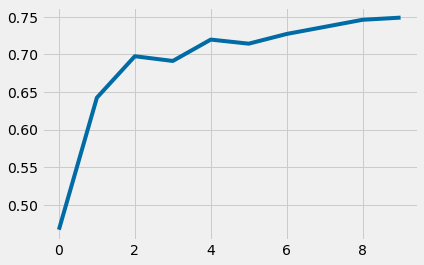

In [120]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) 
          for i in range(10)])

In [121]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.030258941363195842, 0.3870928421087205, 0.9980156686541694, 0.7324048392177893]


In [122]:
preds = np.stack([r.predict(X_valid) for r in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([11.15625,  8.92266,  9.21034,  9.30565,  9.5819 ,  9.15905,  9.15905,  9.21034,  9.43348,  9.39266,
         9.43348,  9.3501 ,  9.54681,  9.6486 ,  8.92266,  9.21034,  9.71112,  9.71112,  9.23503,  8.9872 ]),
 9.414391899879407,
 9.104979856318357)

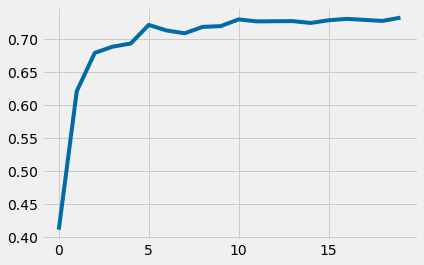

In [123]:
plt.style.use('tableau-colorblind10')
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) 
          for i in range(20)])

In [124]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.025887877681558837, 0.3585445734236037, 0.9985475552230543, 0.7704198783577183]


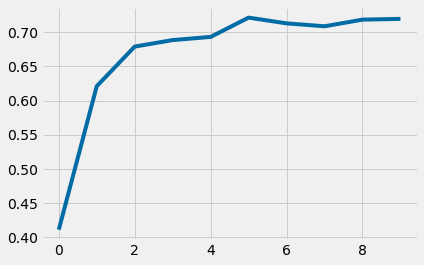

In [125]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) 
          for i in range(10)])

In [126]:
m = RandomForestRegressor(n_estimators=130, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.02235584578134615, 0.3642213785184443, 0.9989168491536744, 0.7630924826930681]


#####  Out of the bag score 

Another technique we can use especially when we have a small dataset that doesn't allow us to split it. Lets say we have fifty rows in our dataset, it would be a difficult to get any insight from such a dataset, in scenarios likes these we can utilize the OOB technique, what it does is that it will pick a different set of rows every time it attempts to build a tree. This allows us to fight over-fitting while using our data efficiently. 

#####  SubSampling

Subsampling is the idea of sampling your dataset on the go, what we mean by on the go is to sample your dataset as whole which is different from the earlier technique which allowed us to sample the data but we were only able to use that same sample data throughout the analysis.
The earlier technique is good for speeding up things because we don't have to run our models on the whole dataset, however, its still vulnerable to over-fitting because it uses the same data. 

In [127]:
len(raw_data)

401125

In [128]:
df_trn, y_trn, nas = proc_df(raw_data, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

To use the sub-sampling idea we need to utilize the fastAi library again, we need  it for it's `rf_samples()`, this methods sets the small sample one would like to use in order to speed up the analysis process

In [129]:
set_rf_samples(20000)

In [130]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 10 s
[0.2414370010997587, 0.27837040080216835, 0.8781732994712048, 0.861613385935003, 0.8654225436891281]


### Tree Building Parameter

In [131]:
reset_rf_samples()

In [132]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min
[0.09050451229176533, 0.24977890233175815, 0.9828811222360078, 0.8885809427429779, -1.3218818863414694]


##### Min_Sample_Leaf

This basically tells the model to stop training on a tree if the model has reached a certain set leaf, it useful because sometimes the model will carry on training even though there is no more insight that can be gained from that branch which risks over-fitting. But with is technique we can put a lasso on our model and the model will train more quickly. It help the model to generalize better but every tree is less good individually

In [133]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11514196323145076, 0.2333333698578383, 0.9722921973079568, 0.9027696877338751, 0.9084692713638227]


In [134]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 54s
[0.11920201032884536, 0.22989330128704094, 0.9703037243592764, 0.9056155156167144, 0.9113996204864292]


Lets get back to the analysis of the subset

In [135]:
raw_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,1,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,1,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,2,S175,...,23,3,204,False,False,False,False,False,False,1248307200


Confidence based on tree variance 

In [136]:
set_rf_samples(50000)

In [137]:
m = RandomForestRegressor(n_estimators= 40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20581847969834158, 0.2482185808242305, 0.9114673308391364, 0.8899686223840851, 0.8944423264233141]


In [138]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]),np.std(preds[:,0])

Wall time: 3.26 s


(9.317098727418037, 0.34519825484528033)

Lets try the same method but using a fastai function, why might we be interested in doing this, well its because python by own its own is slow, because it runs in serial if we selected a larger dataset on set_rf function it would have been alot slower. But if we parallel trees a function from fastai library we are able to run the same process as above except now were doing it in parallel as more than one tree is processed.

In [139]:
#pallarel method it saves time.
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.317098727418037, 0.34519825484528033)

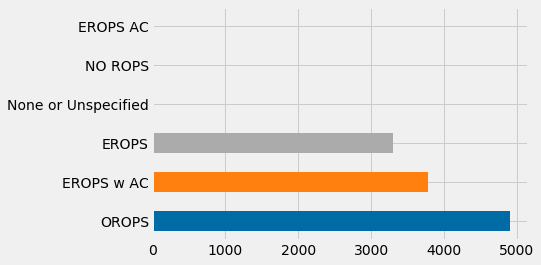

In [140]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

Above we decide to plot a graph to see how well our model is doing by making a copy of our data and checking to see what happens when we plot the Std and Mean vs a number of Enclosure feature.

In [141]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure',as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838711,0.278542
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.571077,0.268837
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682600,0.223360


Important information we can gather from is that the our predictions and are actually close to the actual Sale price thats a sign that our model is working. But on the this table it might still not be clear so we might want to use bar chat to see it more clearly

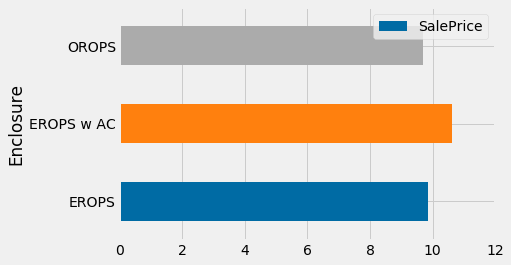

In [142]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,12));

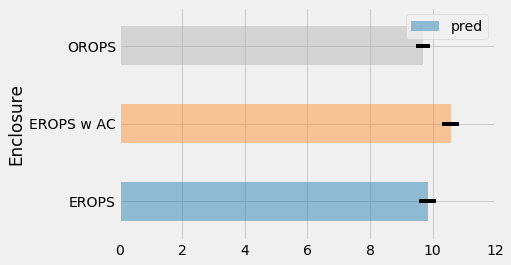

In [143]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=.4 ,xlim=(0,12));

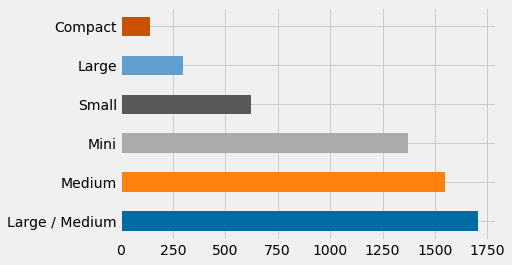

In [144]:
raw_valid.ProductSize.value_counts().plot.barh();

In [145]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
prd_sz = x[flds].groupby('ProductSize',as_index=False).mean()
prd_sz

,ProductSize,SalePrice,pred,pred_std
0,Compact,9.735093,9.839167,0.350345
1,Large,10.470589,10.376584,0.350502
2,Large / Medium,10.691871,10.645337,0.303009
3,Medium,10.681511,10.618045,0.290684
4,Mini,9.535147,9.562574,0.252915
5,Small,10.324448,10.314936,0.314929


Confidence interval can be checked by going feature by feature, but we also group to see how the  group lks but also how each individual is doing.

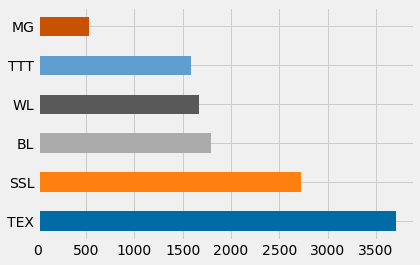

In [146]:
raw_valid.ProductGroup.value_counts().plot.barh()

In [147]:
flds = ['ProductGroup', 'SalePrice', 'pred', 'pred_std']
prd_gp = x[flds].groupby('ProductGroup',as_index=False).mean()
prd_gp

,ProductGroup,SalePrice,pred,pred_std
0,BL,9.911291,9.897933,0.189184
1,MG,10.666625,10.653220,0.265678
2,SSL,9.255687,9.260261,0.207495
3,TEX,10.201039,10.188158,0.286666
4,TTT,10.362547,10.321280,0.271348
5,WL,10.487356,10.427356,0.299068


In [148]:
(prd_sz.pred_std/prd_sz.pred).sort_values(ascending=False)

0    0.035607
1    0.033778
5    0.030531
2    0.028464
3    0.027376
4    0.026448
dtype: float64

### Feature Importance 

This is a way for one to know why the model is making certain predictions by getting a deeper insght into what is actuall going on.

In [149]:
fi = rf_feat_importance(m, df_trn)
fi[:20]

,cols,imp
5,YearMade,0.168872
13,ProductSize,0.094088
37,Coupler_System,0.091010
14,fiProductClassDesc,0.069186
39,Hydraulics_Flow,0.067447
2,ModelID,0.060019
10,fiSecondaryDesc,0.051395
63,saleElapsed,0.049727
19,Enclosure,0.039499
8,fiModelDesc,0.033610


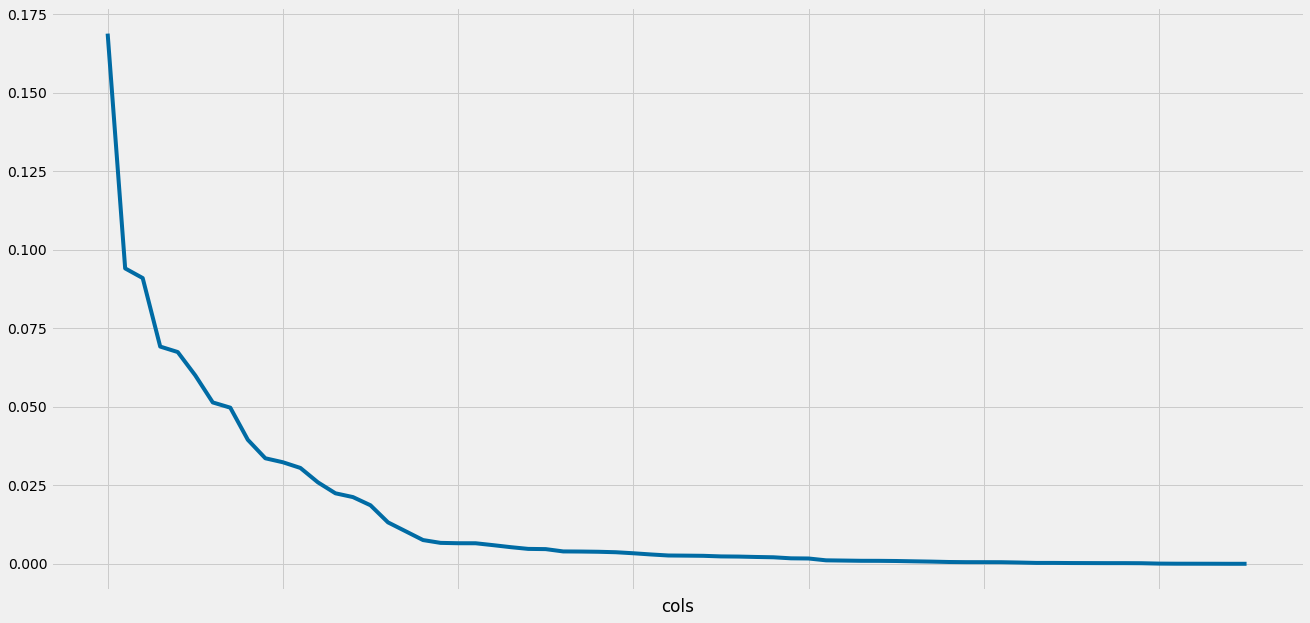

In [150]:
fi.plot('cols', 'imp', figsize=(20,10), legend=False)

In [151]:
fi = rf_feat_importance(m, df_trn); fi[:8]
#fi.plot('cols', 'imp', figsize=(10,6), legend=False)

,cols,imp
5,YearMade,0.168872
13,ProductSize,0.094088
37,Coupler_System,0.091010
14,fiProductClassDesc,0.069186
39,Hydraulics_Flow,0.067447
2,ModelID,0.060019
10,fiSecondaryDesc,0.051395
63,saleElapsed,0.049727


In [152]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(16,10), legend=False)

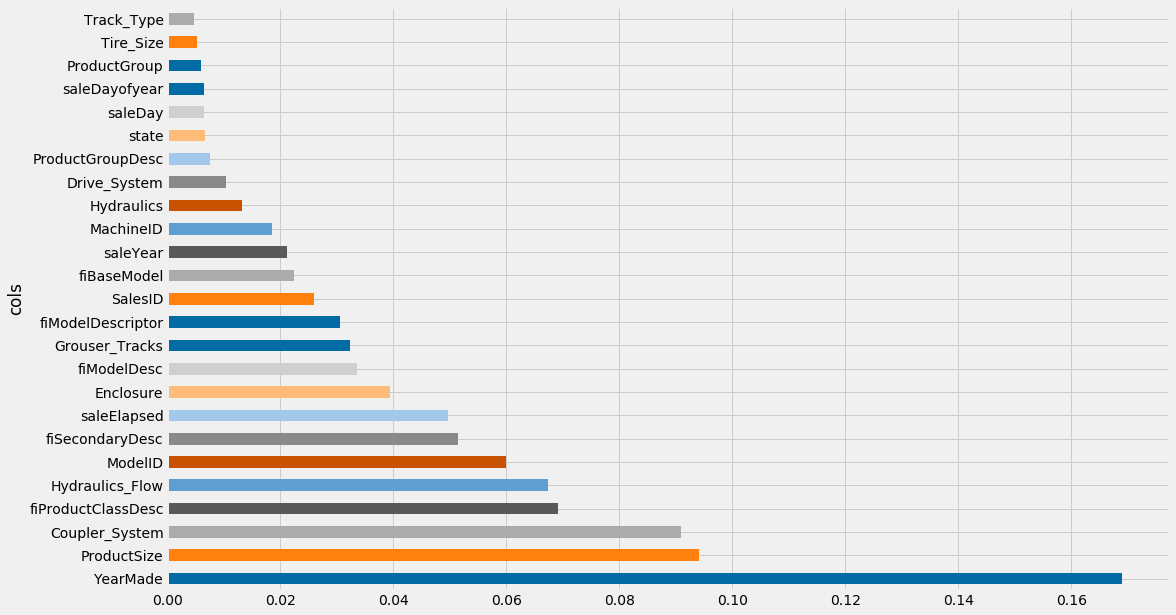

In [153]:
plot_fi(fi[:25])

From the above graph we can see that the three most important features to focus on are; Yearmade, Coupler_System, ProductSize

In [154]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [155]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [156]:
#Creating a anew random forest

m = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2059537326756363, 0.24534748830994307, 0.9113509346676282, 0.8924993211699785, 0.8951062251220248]


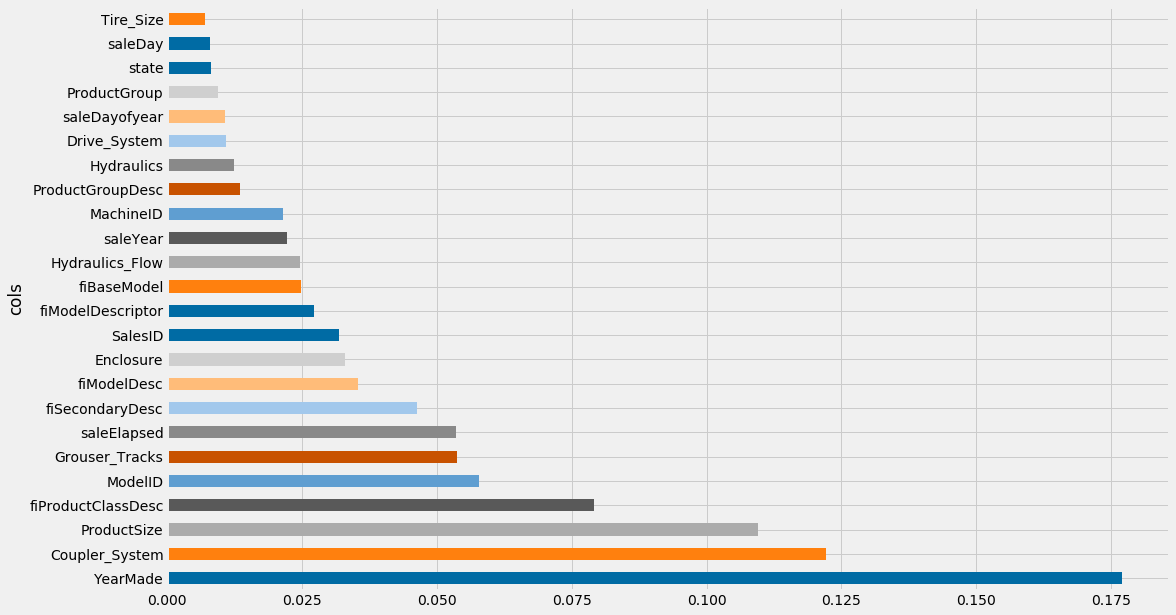

In [157]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

When we remove cols we're also removing colinearity becasue some of the feature might be colinear and if we take out the feature  that is colinear of with another feature, this will highlight the importance of the feature left or the lack of there of.

### Exploring Feature Impact on the model

In order to examine the importance of a feature in  model we have to first examine the candidate (independent variable) features against our dependent variable(SalePrice). YearMade seems to be the most rational choice if one was to pick the most obvious candidate from the above graph.

Let take a deaper looks at YearMade Vs SalePrice, for this we can graph the relationship and see what we can find out.

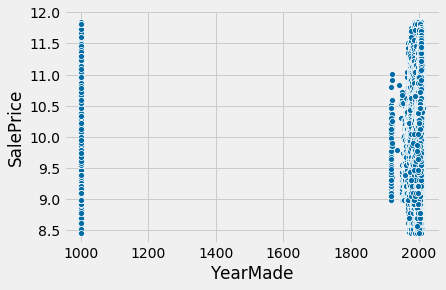

In [158]:
sns.scatterplot(x="YearMade", y="SalePrice", data=raw_train)

Not much information can be drawn here, its suggesting that they sold some bulldozers in the Year 1000, this ludicrous suggestion implies that the recorder of the data had a certain way of recording it and we might want to pay them a visit and ask them to clarify what Year 1000 means or their interpretation of the graph before we carry on.

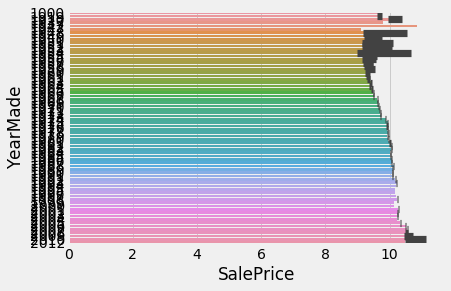

In [159]:
sns.barplot(x="SalePrice", y="YearMade",orient="h", data=raw_train)

Its really going to be difficult to gain anything insightful from this dataset, this means that we have to think of other ways to approach the problem one way of doing that is by trying the *proc_df* function.

For this we shall use a function we encountered earlier, the *pro_df* function. It has an argument  *max_n_cat* which turn categorical variable into new columns. For example lets say we have a feature like relationship, in this relationship we have defined three possible categories. Married, Single and Divorced the we can turn these three categories into feature by defining each added feature as binary choice. Thats to say, we shall have RelationshipMarried, RelationshipSingle, RelationshipDivorced as our new features and dispose of the original Relationship feature. 
What the *max_n_cat* argument does, it makes sure that this will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.The whole process of doing this is what is known as: **One-Hot encoding**

This helps us examine the feature importance at a lower level

Lets run the function and see what sort of impact it will have on our current model 

In [160]:
df_trn2, y_trn, nas = proc_df(raw_data, 'SalePrice', max_n_cat=7)
X_train, X_valid =split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20735202922038729, 0.25319165648828046, 0.9101431053406009, 0.8855154835247252, 0.8923941839241438]


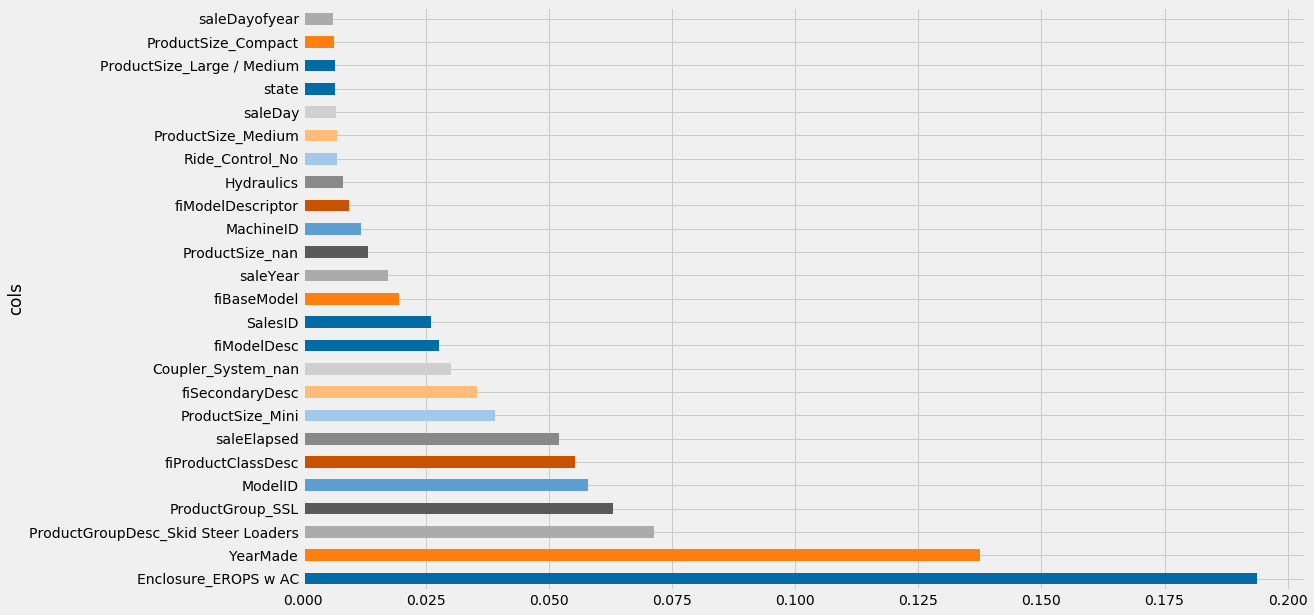

In [161]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Our feature of importance bar chart has changed after running the proc_df, it rearranged the chart. But a closer look we can see some features with equal importance. If two feature have the same effect on the dataset perhaps we can drop some of them and the redundancy caused by them.

### Removing redundant features

If we look at the chart above we can see that some features have redundant features but we cant just base our decision to remove some of the features on just the above chart. We have to examine these redundant features before we drop them.

In [162]:
#Using Scipy library to help us understand the hierarchy of the features

from scipy.cluster import hierarchy as hc

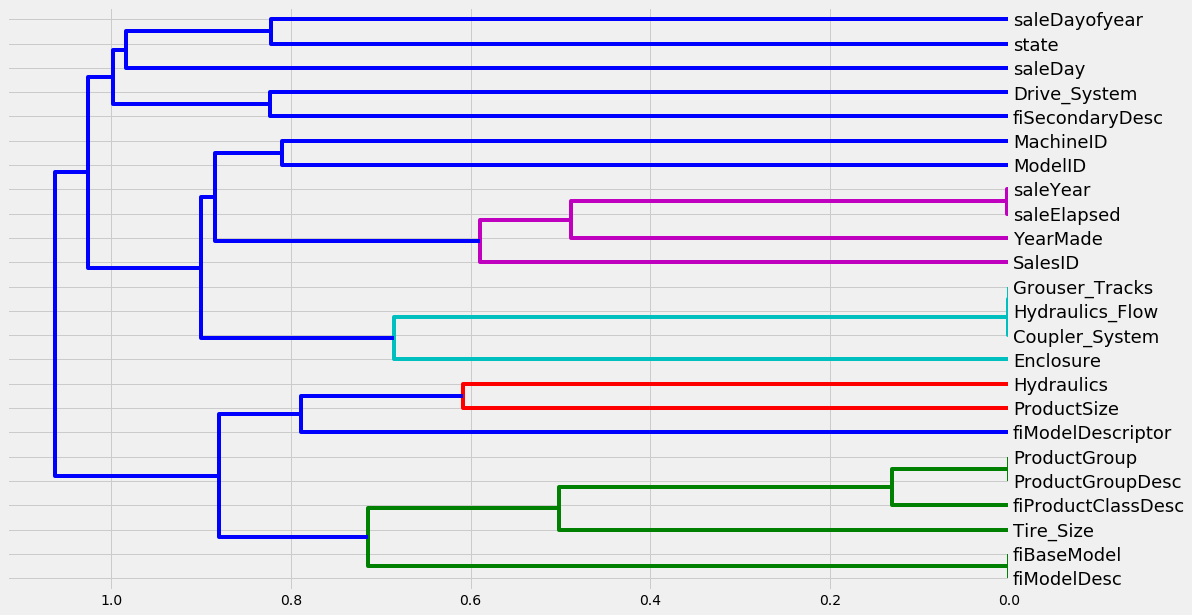

In [163]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condesed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condesed,method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=18)
plt.show()

We shall be focusing on the features that have differences(no correlation) of close to 0.0 on the above graph. We can try to remove those features from our model and see the effect it will have on the overall model.

In [164]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [165]:
get_oob(df_keep)

0.8902521772290223

In [166]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8891472010846606
saleElapsed 0.887665411019741
fiModelDesc 0.8884862999173687
fiBaseModel 0.8894780607958582
Grouser_Tracks 0.8896194023725649
Coupler_System 0.889923505276906


In [167]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8883236859735106

In [168]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [169]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [170]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [171]:
reset_rf_samples()

In [172]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12586377975587154, 0.22664335030200408, 0.9668917393579173, 0.9082652383654104, 0.9084717038085655]


In [173]:
from pdpbox import pdp
from plotnine import *

In [174]:
set_rf_samples(50000)

In [175]:
df_trn3, y_trn, nas = proc_df(raw_data, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn3, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

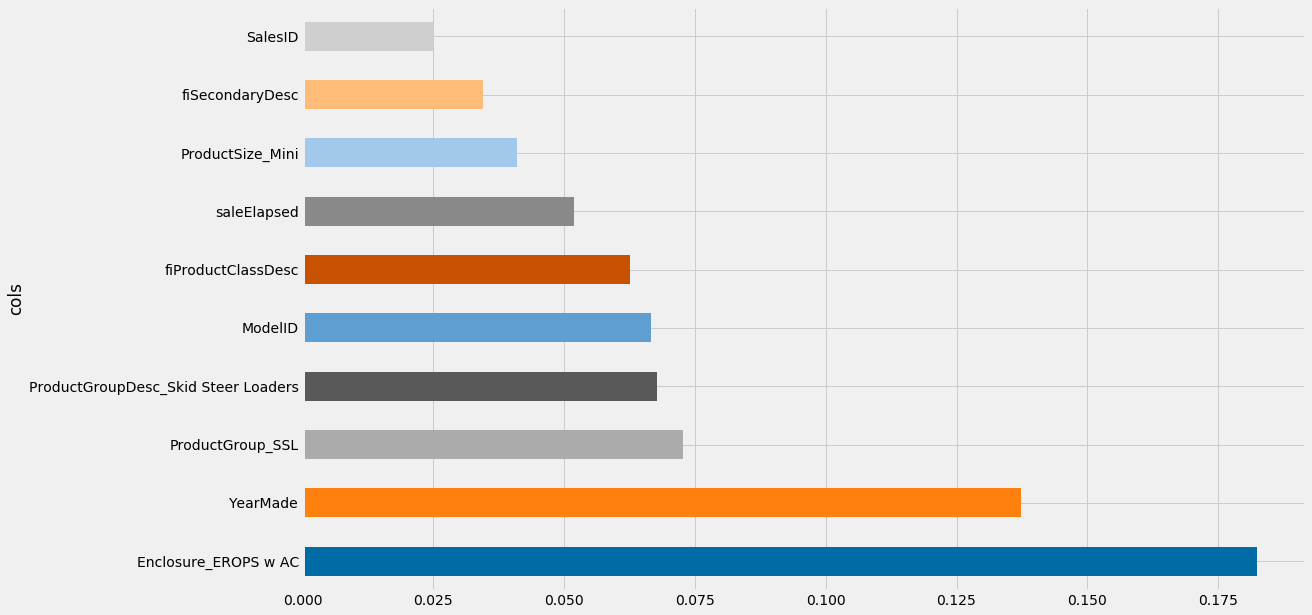

In [176]:
plot_fi(rf_feat_importance(m, df_trn3)[:10]);

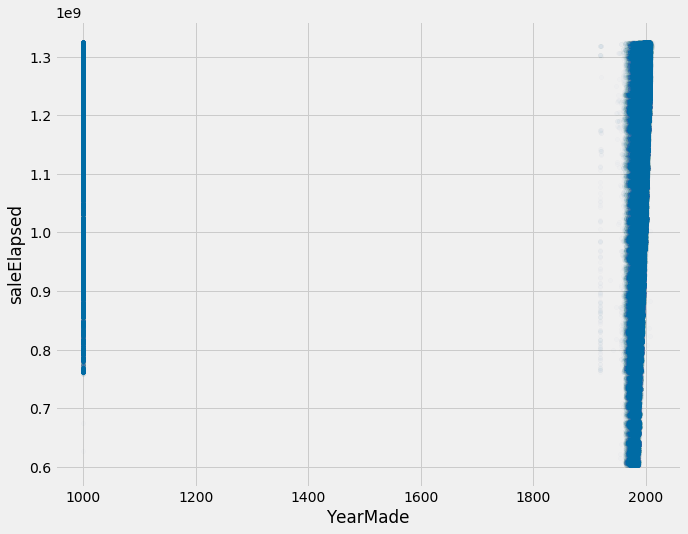

In [177]:
raw_data.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [178]:
x_all = get_sample(raw_data[raw_data.YearMade>1930], 500)

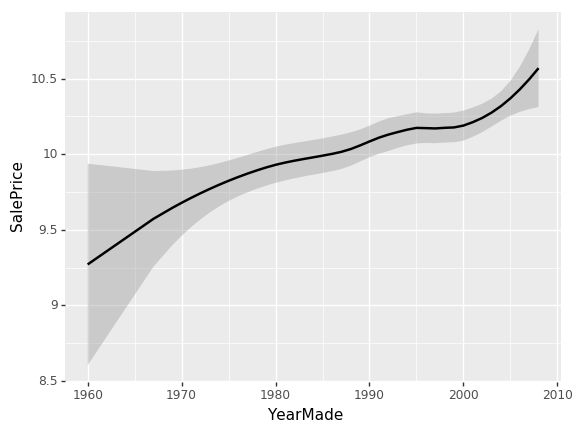

<ggplot: (112877109708)>

In [179]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')